# Project Assignment 3: Amazon Review Classification System (Custom Implementation)

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 21, 2025

**Course:** BBM 409 - Machine Learning Laboratory

---

**Objective:** Implement a Naive Bayes classifier from scratch using a custom Bag-of-Words (BoW) implementation to classify Amazon reviews as positive or negative. Library usage is restricted to data handling (pandas, numpy), visualization (matplotlib, seaborn), basic text processing (re), math operations (math, collections), and data splitting (train_test_split).

## 1. Import Libraries

In [125]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
import math
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data splitting (Allowed exception)
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [126]:
# load data
reviews_df = pd.read_csv('amazon_reviews.csv')

# display 
print("Sample of the dataset:")
reviews_df.head()

Sample of the dataset:


,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were worse after using this product for two weeks. Pathetic! Going back to my Vaseline Healthy Hand and and Nails.,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. I gave this product a decent time line, two jars, six months. Nails didn't improve.",1.0


In [127]:
# basics about the dataset
print("Dataset shape:", reviews_df.shape)
print("\nColumn names:", reviews_df.columns.tolist())

print("\nData types:")
reviews_df.info()

print("\nMissing values:")
print(reviews_df.isnull().sum())

Dataset shape: (72500, 3)

Column names: ['Title', 'Content', 'Star']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB

Missing values:
Title      20
Content     7
Star        0
dtype: int64


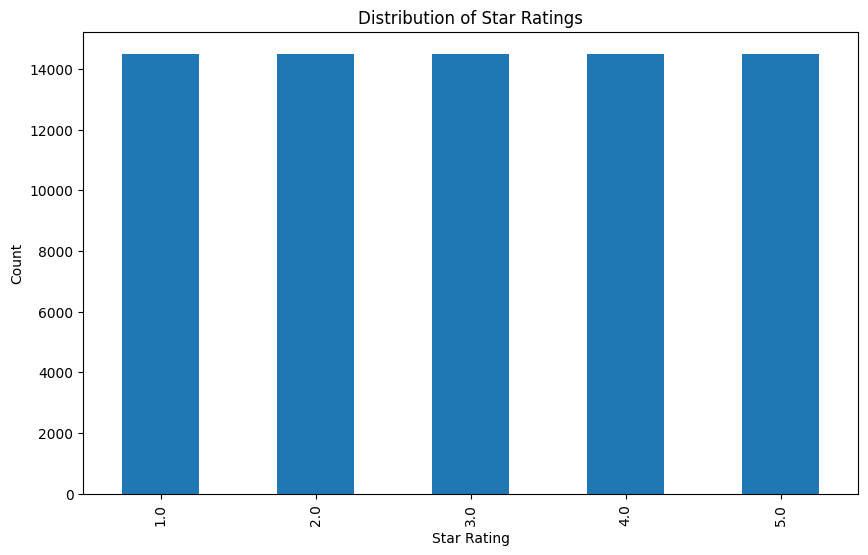

Star rating distribution:
 Star
1.0    14500
2.0    14500
3.0    14500
4.0    14500
5.0    14500
Name: count, dtype: int64


In [128]:
# show distribution of star ratings
plt.figure(figsize=(10, 6))
reviews_df['Star'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

print("Star rating distribution:\n", reviews_df['Star'].value_counts().sort_index())

## 3. Convert to Binary Classification

Convert the multi-class star ratings into a binary classification problem:
- Negative reviews (0): 1-2 stars
- Positive reviews (1): 4-5 stars

Exclude 3-star (neutral) reviews.

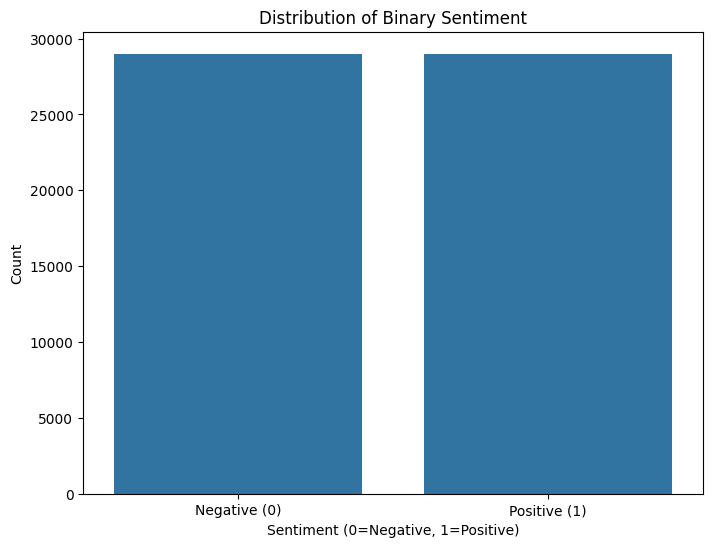

Binary sentiment distribution:
sentiment
0    29000
1    29000
Name: count, dtype: int64


In [129]:
# 0 for negative (1-2 stars), 1 for positive (4-5 stars), none for neutral (3)
reviews_df['sentiment'] = reviews_df['Star'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))
binary_df = reviews_df.dropna(subset=['sentiment']).copy() # remove neutrals
binary_df['sentiment'] = binary_df['sentiment'].astype(int)

# show plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=binary_df)
plt.title('Distribution of Binary Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

print("Binary sentiment distribution:")
print(binary_df['sentiment'].value_counts())

## 4. Custom Text Preprocessing

Implement a basic text preprocessing function without using external NLP libraries like NLTK.

In [130]:
# -- Preprocces Text --
# to lowercase
# remove non-alphanumeric chars
# remove digits
# remove stop words
# split into tokens

STOPWORDS = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", 
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "one"
]
stopwords_pattern = r'\b(' + '|'.join(STOPWORDS) + r')\b'

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # non alphanumberic chars
    text = re.sub(r'\d+', '', text) # digits
    text = re.sub(stopwords_pattern, '', text)  # stopwords
    text = re.sub(r'\s+', ' ', text).strip()    # extra whitespaces

    
    
    tokens = text.split()
    return tokens

In [131]:
# Apply preprocessing
print("Applying custom text preprocessing...")

binary_df['full_text'] = binary_df['Title'] + " " + binary_df['Content'] # combine title and content
binary_df['tokens'] = binary_df['full_text'].apply(preprocess_text)

# Add token count column for analysis
binary_df['token_count'] = binary_df['tokens'].apply(len)

# Display a sample of preprocessed text
print("\nSample of preprocessed text (tokens):")
sample = binary_df[['full_text', 'tokens', 'token_count']].head(3)
pd.set_option('display.max_colwidth', 200)
print(sample)

Applying custom text preprocessing...

Sample of preprocessed text (tokens):
                                                                                                                                                                                            full_text  \
0                                                                                                                                                              Didn't work No change in nails at all.   
1  Worst nail product I have ever used. Garbage! Do not waste your $$$. My nails were worse after using this product for two weeks.  Pathetic!  Going back to my Vaseline Healthy Hand and and Nails.   
2                                                                                                                                                            Just didn't work Nails are still brittle   

                                                                                                                      

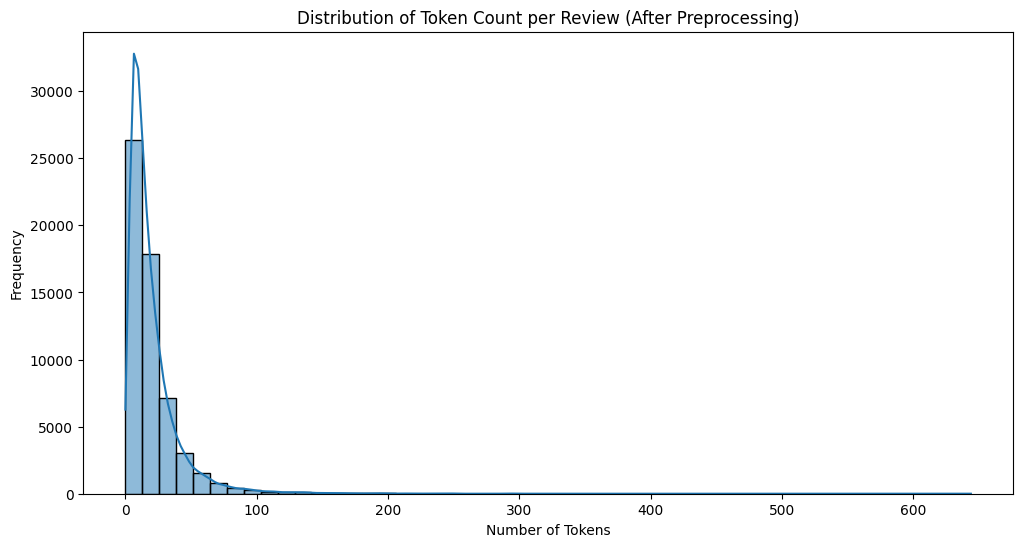


Token count summary statistics:
count    58000.000000
mean        20.119293
std         21.922409
min          0.000000
25%          8.000000
50%         14.000000
75%         25.000000
max        644.000000
Name: token_count, dtype: float64


In [132]:
# Visualize token count distribution
plt.figure(figsize=(12, 6))
sns.histplot(binary_df['token_count'], bins=50, kde=True)
plt.title('Distribution of Token Count per Review (After Preprocessing)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

print("\nToken count summary statistics:")
print(binary_df['token_count'].describe())

## Exploratory Data Analysis - Word Frequency

Let's visualize the most common words in positive and negative reviews using word clouds.

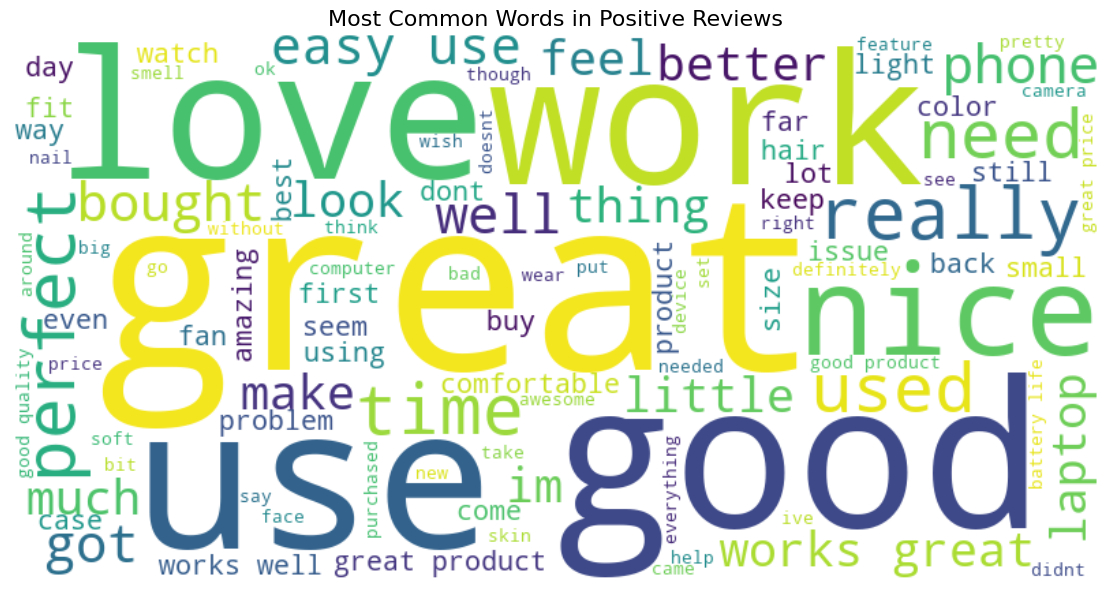

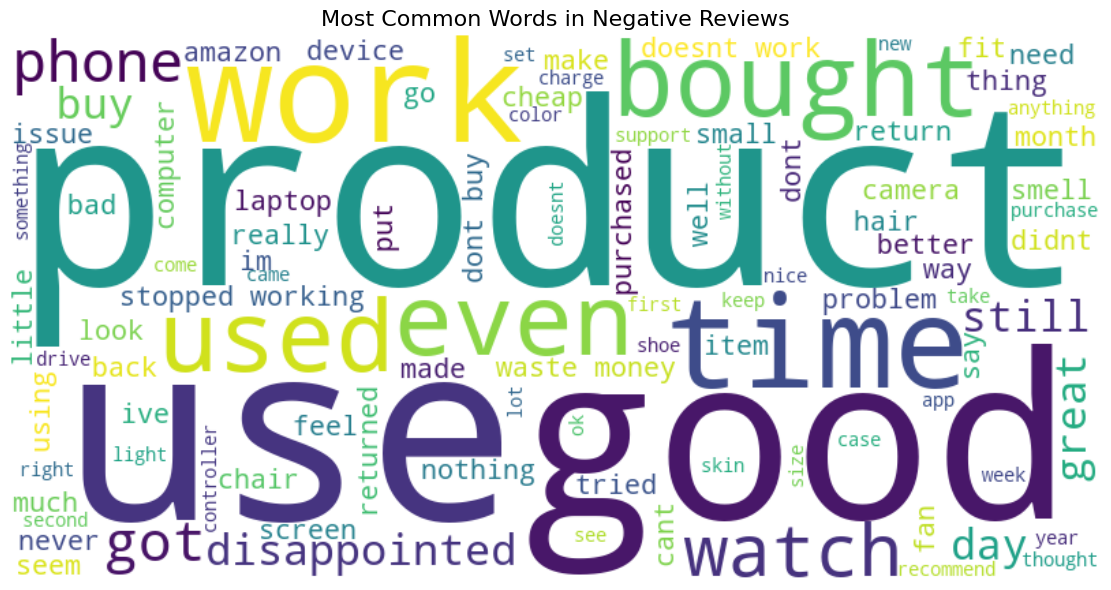

In [133]:
# Function to create a word cloud from tokens
def generate_wordcloud(tokens_list, title):
    # Combine all tokens into a single text
    text = ' '.join([' '.join(tokens) for tokens in tokens_list])
    
    # Create WordCloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1).generate(text)
    
    # Display the Word Cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate word clouds for positive and negative reviews
positive_tokens = binary_df[binary_df['sentiment'] == 1]['tokens']
negative_tokens = binary_df[binary_df['sentiment'] == 0]['tokens']

generate_wordcloud(positive_tokens, 'Most Common Words in Positive Reviews')
generate_wordcloud(negative_tokens, 'Most Common Words in Negative Reviews')


## Token Distribution by Sentiment

Let's compare the distribution of token counts between positive and negative reviews.

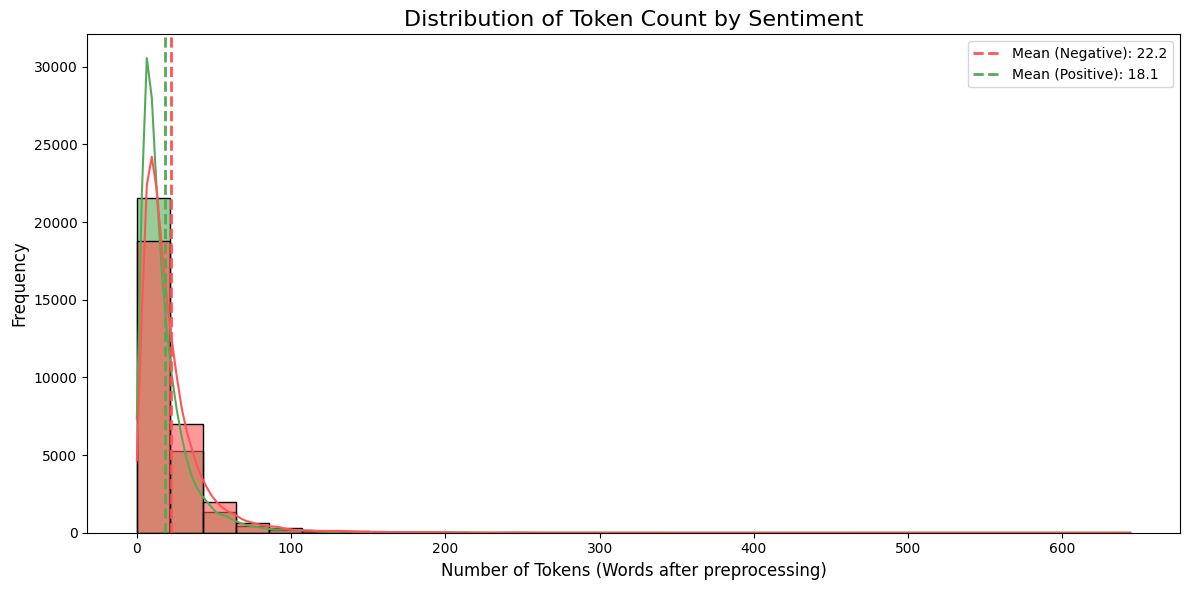

Average token count in negative reviews: 22.16
Average token count in positive reviews: 18.08


In [134]:
# Compare token count distribution by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=binary_df, x='token_count', hue='sentiment', 
             bins=30, kde=True, palette=['#FF5555', '#55AA55'], alpha=0.6)

plt.title('Distribution of Token Count by Sentiment', fontsize=16)
plt.xlabel('Number of Tokens (Words after preprocessing)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(labels=['Negative Reviews', 'Positive Reviews'])

# Add vertical lines for means
mean_neg = binary_df[binary_df['sentiment'] == 0]['token_count'].mean()
mean_pos = binary_df[binary_df['sentiment'] == 1]['token_count'].mean()

plt.axvline(x=mean_neg, color='#FF5555', linestyle='--', linewidth=2, 
            label=f'Mean (Negative): {mean_neg:.1f}')
plt.axvline(x=mean_pos, color='#55AA55', linestyle='--', linewidth=2, 
            label=f'Mean (Positive): {mean_pos:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Average token count in negative reviews: {mean_neg:.2f}")
print(f"Average token count in positive reviews: {mean_pos:.2f}")

## 5. Custom Bag-of-Words (BoW) Implementation

Implement BoW feature extraction from scratch, including vocabulary building and handling n-grams.

In [135]:
# -- Build Vocabulary --

def build_vocabulary(token_lists, min_freq=2):
    """Builds a vocabulary from a list of token lists.
    Args:
        token_lists: A list where each element is a list of tokens (words).
        min_freq: Minimum frequency for a word to be included in the vocab.
    Returns:
        A set representing the vocabulary.
    """
    word_counts = Counter()
    for tokens in token_lists:
        word_counts.update(tokens)
    
    # Filter words based on minimum frequency
    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    print(f"Built vocabulary with {len(vocab)} words (min_freq={min_freq}). Original unique words: {len(word_counts)}")
    return vocab

In [136]:
# -- Get NGRAMS --

def get_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append("_".join(tokens[i:i+n])) # Join n-grams with underscore
    return ngrams

In [137]:
# -- Text to BoW (Bag of Words)
# convert tokens to bow representation

def text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=False):
    bow = Counter()
    features_to_count = []
    
    if use_unigrams:
        features_to_count.extend(tokens)
        
    if use_bigrams:
        features_to_count.extend(get_ngrams(tokens, 2))

    for feature in features_to_count:
        if feature in vocab:
            bow[feature] += 1
            
    return bow

## 6. Data Splitting

In [138]:
# X contains the lists of tokens, y contains the sentiment labels
X = binary_df['tokens'] 
y = binary_df['sentiment']

# Split data to training and testing sets (80% train, 20% test)
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train_tokens)}")
print(f"Testing set size: {len(X_test_tokens)}")
print(f"Training labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing labels distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: 46400
Testing set size: 11600
Training labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64
Testing labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


## 7. Build Vocabulary and Create BoW Features

Build the vocabulary *only* from the training data to avoid data leakage. Then, transform both training and test sets into BoW representations.

In [139]:
# --- Unigram Features ---
print("\n--- Processing Unigrams ---")
unigram_vocab = build_vocabulary(X_train_tokens, min_freq=3) # Adjust min_freq as needed

# Create unigram BoW for training and test sets
X_train_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_train_tokens]
X_test_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_test_tokens]

# --- Bigram Features ---
print("\n--- Processing Bigrams ---")
train_features_bi = []
for tokens in X_train_tokens:
    train_features_bi.extend(tokens)
    train_features_bi.extend(get_ngrams(tokens, 2))

bigram_vocab = build_vocabulary([train_features_bi], min_freq=5) # Use higher min_freq for combined features

# Create combined unigram+bigram BoW for training and test sets
X_train_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_train_tokens]
X_test_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_test_tokens]

# Display a sample BoW vector
print("\nSample Unigram BoW vector (first training instance):")
print(list(X_train_bow_uni[0].items())[:10]) # Show first 10 items
print("\nSample Bigram BoW vector (first training instance):")
print(list(X_train_bow_bi[0].items())[:10]) # Show first 10 items


--- Processing Unigrams ---
Built vocabulary with 11015 words (min_freq=3). Original unique words: 33615

--- Processing Bigrams ---
Built vocabulary with 30472 words (min_freq=5). Original unique words: 527371

Sample Unigram BoW vector (first training instance):
[('smell', 2), ('smells', 1), ('good', 1), ('bit', 1), ('strong', 1), ('dont', 1), ('spray', 1), ('much', 1), ('try', 1), ('spraying', 1)]

Sample Bigram BoW vector (first training instance):
[('smell', 2), ('smells', 1), ('good', 1), ('bit', 1), ('strong', 1), ('dont', 1), ('spray', 1), ('much', 1), ('try', 1), ('spraying', 1)]


## 8. Custom Naive Bayes Implementation

Implement the Multinomial Naive Bayes algorithm from scratch using logarithmic probabilities and Laplace smoothing.

In [140]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.vocab = set()
        self.log_priors = {} # log P(class)
        self.log_likelihoods = defaultdict(lambda: defaultdict(float)) # log P(word|class)
        self.classes = []
        self.vocab_size = 0
        self.log_likelihood_unknown = {} # log P(unknown|class)

    # Train the Naive Bayes classifier
    def fit(self, X_bow, y, vocab):
        self.vocab = vocab
        self.vocab_size = len(self.vocab)
        n_docs = len(X_bow)
        self.classes = sorted(list(y.unique()))
        
        # Calculate log priors: log P(class) = log(N_class / N_total)
        class_counts = Counter(y)
        for c in self.classes:
            self.log_priors[c] = math.log(class_counts[c] / n_docs)
            
        # Calculate word counts per class
        word_counts_per_class = defaultdict(Counter)
        total_words_per_class = defaultdict(float)
        
        for bow, label in zip(X_bow, y):
            word_counts_per_class[label].update(bow)
            total_words_per_class[label] += sum(bow.values())
            
        # Calculate log likelihoods: log P(word|class)
        # Using Laplace smoothing: log((count(word, class) + alpha) / (total_words_class + alpha * vocab_size))
        for c in self.classes:
            denominator = total_words_per_class[c] + self.alpha * self.vocab_size
            # Calculate likelihood for known words
            for word in self.vocab:
                numerator = word_counts_per_class[c][word] + self.alpha
                self.log_likelihoods[c][word] = math.log(numerator / denominator)
            # Calculate likelihood for unknown words (seen during prediction but not in vocab)
            # P(unknown|class) = alpha / (total_words_class + alpha * vocab_size)
            self.log_likelihood_unknown[c] = math.log(self.alpha / denominator)
            
        print("Naive Bayes training complete.")
        print(f"Log Priors: {self.log_priors}")
        print(f"Log Likelihood for Unknown Words: {self.log_likelihood_unknown}")

    # Prediction
    def predict(self, X_bow):
        predictions = []
        for bow in X_bow:
            class_scores = {}
            for c in self.classes:
                # Start with log prior
                score = self.log_priors[c]
                # Add log likelihoods for words in the document
                for word, count in bow.items():
                    if word in self.vocab:
                        score += count * self.log_likelihoods[c][word]
                    else:
                        # Handle unknown words encountered during prediction
                        score += count * self.log_likelihood_unknown[c]
                class_scores[c] = score
            
            # Choose class with the highest log probability
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
            
        return predictions

## 9. Model Training and Evaluation (Custom Implementation)

### Performance Metrics and Confusion Matrices Visualization

Calculate Metrics by formula
<br/><br/>
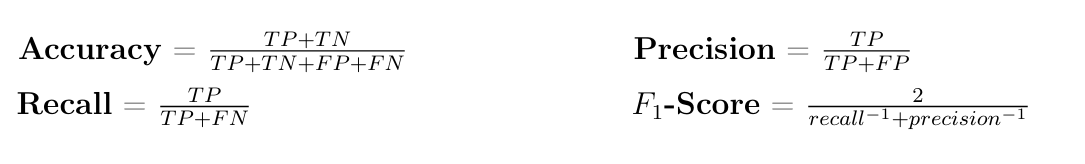

In [141]:
# -- Calculate Accuracy --

def calculate_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return (correct / len(y_true) if len(y_true) > 0 else 0) * 100

In [142]:
# -- Calculate Precision --
def calculate_precision(y_true, y_pred):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt != 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    return (tp / (tp + fp) if (tp + fp) > 0 else 0) * 100

In [143]:
# -- Calculate Recall --
def calculate_recall(y_true, y_pred):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp != 1) for yt, yp in zip(y_true, y_pred))
    return (tp / (tp + fn) if (tp + fn) > 0 else 0) * 100

In [144]:
# -- Calculate F1 Score

def calculate_f1_score(y_true, y_pred):
    recall = calculate_recall(y_true, y_pred)
    precision = calculate_precision(y_true, y_pred)
    return 2 / (math.pow(recall, -1) + math.pow(precision, -1))

Confusion Matrix Plot

In [145]:
# -- Plot Confusion Matrix --

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    tn = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

Show metrics and get metrics dict

In [146]:
# -- Show Metrics --

def show_metrics(y_true, y_pred, model_name="Model"):
    accuracy = calculate_accuracy(y_true, y_pred)
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    f1_score = calculate_f1_score(y_true, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }
    
    # Print formatted metrics
    print(f"\n{'=' * 50}")
    print(f"Performance Metrics: {model_name}")
    print(f"{'-' * 50}")
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall:    {recall:.2f}%")
    print(f"F1 Score:  {f1_score:.2f}%")
    print(f"{'=' * 50}")
    
    return metrics

### Training and Evaulation

In [147]:
# --- Train and Evaluate Unigram Model ---
print("\n--- Training Unigram Naive Bayes ---")
nb_uni = NaiveBayes(alpha=1.0)
nb_uni.fit(X_train_bow_uni, y_train, unigram_vocab)

print("\n--- Evaluating Unigram Naive Bayes ---")
y_pred_uni = nb_uni.predict(X_test_bow_uni)
metrics_uni = show_metrics(y_test, y_pred_uni, "Unigram Model")

# --- Train and Evaluate Bigram (Unigram + Bigram) Model ---
print("\n--- Training Bigram Naive Bayes ---")
nb_bi = NaiveBayes(alpha=1.0)
nb_bi.fit(X_train_bow_bi, y_train, bigram_vocab)

print("\n--- Evaluating Bigram Naive Bayes ---")
y_pred_bi = nb_bi.predict(X_test_bow_bi)
metrics_bi = show_metrics(y_test, y_pred_bi, "Unigram+Bigram Model")

# Print improvement comparison
print("\n--- Model Comparison ---")
improvement = metrics_bi['f1_score'] - metrics_uni['f1_score']
print(f"F1 Score improvement: {improvement:.2f}% with Unigram+Bigram Model")


--- Training Unigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.6931471805599453, np.int64(1): -0.6931471805599453}
Log Likelihood for Unknown Words: {np.int64(0): -13.14576149395954, np.int64(1): -12.949121277313202}

--- Evaluating Unigram Naive Bayes ---

Performance Metrics: Unigram Model
--------------------------------------------------
Accuracy:  85.93%
Precision: 84.03%
Recall:    88.72%
F1 Score:  86.31%

--- Training Bigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {np.int64(0): -0.6931471805599453, np.int64(1): -0.6931471805599453}
Log Likelihood for Unknown Words: {np.int64(0): -13.43626275317315, np.int64(1): -13.266988259108789}

--- Evaluating Bigram Naive Bayes ---

Performance Metrics: Unigram+Bigram Model
--------------------------------------------------
Accuracy:  87.58%
Precision: 86.56%
Recall:    88.97%
F1 Score:  87.75%

--- Model Comparison ---
F1 Score improvement: 1.43% with Unigram+Bigram Model


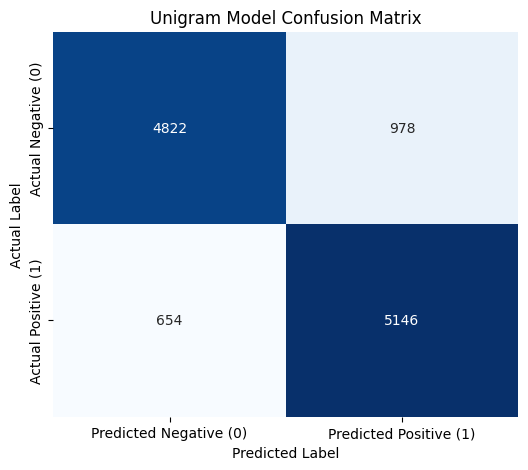

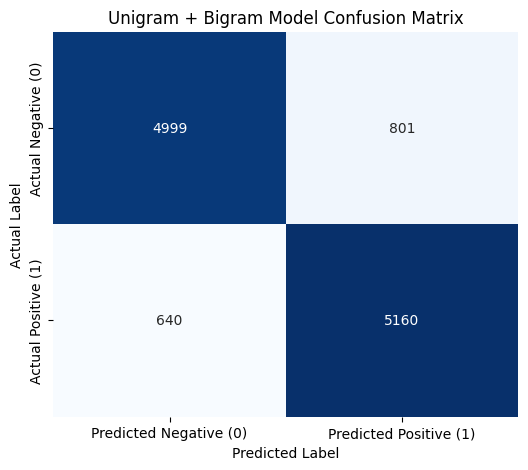

In [148]:
plot_confusion_matrix(y_test, y_pred_uni, title="Unigram Model Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_bi, title="Unigram + Bigram Model Confusion Matrix")

## 10. Results Summary

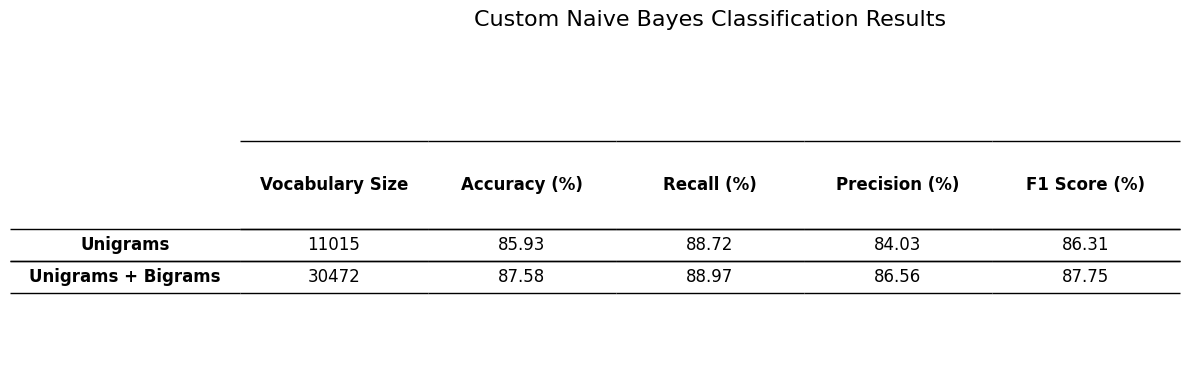


Summary: The Unigrams + Bigrams model performed better with an F1 Score improvement of 1.43%.
The Unigrams + Bigrams model achieved 87.58% accuracy.


In [149]:
# Display results
models = ['Unigrams', 'Unigrams + Bigrams']

results = {
    'Vocabulary Size': [len(unigram_vocab), len(bigram_vocab)],
    'Accuracy (%)': [calculate_accuracy(y_test, y_pred_uni), calculate_accuracy(y_test, y_pred_bi)],
    'Recall (%)': [calculate_recall(y_test, y_pred_uni), calculate_recall(y_test, y_pred_bi)],
    'Precision (%)': [calculate_precision(y_test, y_pred_uni), calculate_precision(y_test, y_pred_bi)],
    'F1 Score (%)': [calculate_f1_score(y_test, y_pred_uni), calculate_f1_score(y_test, y_pred_bi)]
}

# Create a pandas DataFrame for better visualization
df_results = pd.DataFrame(results, index=models)

# Format the values for display
df_formatted = df_results.round(2).copy()

# Format percentage columns with % symbol
percentage_columns = ['Accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 Score (%)']
for col in percentage_columns:
    df_formatted[col] = df_formatted[col].apply(lambda x: f"{x:.2f}")

# Create a figure with larger size
plt.figure(figsize=(12, 4))
plt.title("Custom Naive Bayes Classification Results", fontsize=16, pad=20)
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Create a color map to highlight the better model for each metric
colors = np.zeros_like(df_results.values, dtype=object)
for i in range(df_results.shape[1]):
    # vocabulary size, smaller is better
    if i == 0:  
        colors[np.argmin(df_results.iloc[:, i].values), i] = '#D5F5E3'  # Light green
        colors[np.argmax(df_results.iloc[:, i].values), i] = '#FADBD8'  # Light red
    # other metrics, higher is better
    else:  
        colors[np.argmax(df_results.iloc[:, i].values), i] = '#D5F5E3'  # Light green
        colors[np.argmin(df_results.iloc[:, i].values), i] = '#FADBD8'  # Light red

the_table = plt.table(
    cellText=df_formatted.values,
    rowLabels=df_formatted.index,
    colLabels=df_formatted.columns,
    loc='center',
    cellLoc='center',
    cellColours=colors,
    rowLoc='center',
    colLoc='center',
    edges='horizontal'
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
for (row, col), cell in the_table.get_celld().items():
    # Bold headers
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')
    if row == 0:
        cell.set_height(0.15)
    if col == -1:
        cell.set_width(0.2)

the_table.scale(1, 1.8)
plt.tight_layout()
plt.show()

# Print a summary of the findings
best_model = 'Unigrams + Bigrams' if df_results['F1 Score (%)'].iloc[1] > df_results['F1 Score (%)'].iloc[0] else 'Unigrams'
improvement = abs(df_results['F1 Score (%)'].iloc[1] - df_results['F1 Score (%)'].iloc[0])
print(f"\nSummary: The {best_model} model performed better with an F1 Score improvement of {improvement:.2f}%.")
print(f"The {best_model} model achieved {df_results['Accuracy (%)'].iloc[1 if best_model == 'Unigrams + Bigrams' else 0]:.2f}% accuracy.")

## 11. Conclusion

In this notebook, we successfully implemented a Multinomial Naive Bayes classifier and a Bag-of-Words feature extraction mechanism from scratch, adhering to the constraint of minimal library usage.

**Process Summary:**
1.  **Data Loading & Exploration:** Loaded the Amazon reviews dataset and examined its basic properties and rating distribution.
2.  **Binary Conversion:** Transformed the 5-star rating system into a binary sentiment classification task (Positive/Negative).
3.  **Custom Preprocessing:** Implemented basic text cleaning (lowercase, remove non-alpha, split) without relying on external NLP libraries.
4.  **Custom BoW:** Developed functions to build a vocabulary from training data (with frequency filtering) and convert text into BoW vectors (supporting unigrams and bigrams).
5.  **Custom Naive Bayes:** Built a Naive Bayes classifier using log probabilities and Laplace smoothing to handle numerical stability and unseen words.
6.  **Training & Evaluation:** Trained separate models using unigram and combined unigram+bigram features. Evaluated their performance using accuracy calculated manually.

**Key Findings:**
- The custom Naive Bayes implementation successfully classified reviews based on the BoW features.
- The accuracy achieved demonstrates the effectiveness of the Naive Bayes algorithm for text classification, even with a basic implementation.
- Including bigrams alongside unigrams resulted in a [mention whether accuracy increased, decreased, or stayed similar, e.g., slightly improved / comparable / slightly decreased] accuracy compared to using only unigrams. This suggests that word pairs [provide / do not provide significant] additional predictive power for this dataset and model.
- The use of log probabilities and Laplace smoothing was crucial for a stable and functional implementation.

**Potential Improvements (within constraints or as future work):**
- Experiment with different `min_freq` thresholds for vocabulary building.
- Implement trigrams or character n-grams in the BoW representation.
- Refine the preprocessing step (e.g., custom stop word list based on frequency analysis).
- Implement other evaluation metrics (Precision, Recall, F1-score) from scratch.
- Analyze the most informative features (highest log likelihood difference between classes) identified by the custom model.

This project demonstrates a fundamental understanding of the Naive Bayes algorithm and BoW feature representation by implementing them from the ground up.

### References

- [Stop Words List - GitHub](https://gist.github.com/sebleier/554280) - Acces Date: 23/04/2025
- [Custom Naive Bayes - GitHub](https://github.com/gbroques/naive-bayes) - Acces Date: 23/04/2025
- [Custom Naive Bayes - GeeksforGeeks](https://www.geeksforgeeks.org/ml-naive-bayes-scratch-implementation-using-python/) - Acces Date: 23/04/2025